# Link Prediction on LastFM music dataset- Pytorch Geometric (Not my Master thesis!)

This Jupyter notebook demonstrates **link prediction** using **Graph Neural Networks (GNNs)** on the **LastFM** dataset with **PyTorch Geometric**. The task is to **predict potential links between users and artists in a heterogeneous bipartite graph**, where the **nodes represent users and artists**, and the **edges represent user interactions with artists**. By applying GNN-based techniques, we aim to predict missing or future edges between users and artists, utilizing the graph's structure and node features to enhance the accuracy of the predictions.

This is **not my Master thesis**. It was just a short example that I worked on to understand the fundamentals of how GNNs can be used to approach the problem of Link prediction. **The Master Thesis invovles more thorough research and experimentation based on recent research papers and on a real-life dataset from the city of Brønderslev, Denmark**

In [130]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import torch.nn.functional as F


from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from torch.nn import ModuleList, Linear
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import LastFM
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero, global_add_pool

In [131]:
args = dict()
args["val_ratio"] = 0.1
args["test_ratio"] = 0.1
args["neg_sampling_ratio"] = 1.0
args["num_neighbors"] = 10
args["num_hops"] = 3
args["hidden_channels"] = 10
args["num_layers"] = 3
args["lr"] = 0.0001
args["epochs"] = 10

In [132]:
dataset = LastFM(root="../dataset")
print(f"Number of graphs: {len(dataset)}")

Number of graphs: 1


In [133]:
data = dataset[0]

In [134]:
data = dataset[0]
data

HeteroData(
  user={ num_nodes=1892 },
  artist={ num_nodes=17632 },
  tag={ num_nodes=1088 },
  (user, to, artist)={
    train_neg_edge_index=[2, 33294760],
    val_pos_edge_index=[2, 9283],
    val_neg_edge_index=[2, 9283],
    test_pos_edge_index=[2, 18567],
    test_neg_edge_index=[2, 18567],
    edge_index=[2, 64984],
  },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, to, user)={ edge_index=[2, 64984] },
  (artist, to, tag)={ edge_index=[2, 23253] },
  (tag, to, artist)={ edge_index=[2, 23253] }
)

In [135]:
data_new = HeteroData()
data_new["user"].node_id = torch.arange(data["user"].num_nodes)
data_new["artist"].node_id = torch.arange(data["artist"].num_nodes)
data_new["user", "to", "artist"].edge_index = torch.cat((data["user", "to", "artist"].edge_index, data["user", "to", "artist"].val_pos_edge_index, data["user", "to", "artist"].test_pos_edge_index), dim=1)
data_new = T.ToUndirected()(data_new)
data_new

HeteroData(
  user={ node_id=[1892] },
  artist={ node_id=[17632] },
  (user, to, artist)={ edge_index=[2, 92834] },
  (artist, rev_to, user)={ edge_index=[2, 92834] }
)

In [136]:
split_transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=1.0,
    add_negative_train_samples=True,
    edge_types=("user", "to", "artist"),
    rev_edge_types=("artist", "rev_to", "user"),
)

In [137]:
train_dataset, val_dataset, test_dataset = split_transform(data_new)
train_dataset, val_dataset, test_dataset

(HeteroData(
   user={ node_id=[1892] },
   artist={ node_id=[17632] },
   (user, to, artist)={
     edge_index=[2, 74268],
     edge_label=[148536],
     edge_label_index=[2, 148536],
   },
   (artist, rev_to, user)={ edge_index=[2, 74268] }
 ),
 HeteroData(
   user={ node_id=[1892] },
   artist={ node_id=[17632] },
   (user, to, artist)={
     edge_index=[2, 74268],
     edge_label=[18566],
     edge_label_index=[2, 18566],
   },
   (artist, rev_to, user)={ edge_index=[2, 74268] }
 ),
 HeteroData(
   user={ node_id=[1892] },
   artist={ node_id=[17632] },
   (user, to, artist)={
     edge_index=[2, 83551],
     edge_label=[18566],
     edge_label_index=[2, 18566],
   },
   (artist, rev_to, user)={ edge_index=[2, 83551] }
 ))

In [138]:
num_neighbors = [args["num_neighbors"]] * args["num_hops"]

train_loader = LinkNeighborLoader(
    data=data_new,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", "to", "artist"), train_dataset["user", "to", "artist"].edge_label_index),
    edge_label=train_dataset["user", "to", "artist"].edge_label,
    subgraph_type="bidirectional",
    neg_sampling=None,
    batch_size=32,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data_new,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", "to", "artist"), val_dataset["user", "to", "artist"].edge_label_index),
    edge_label=val_dataset["user", "to", "artist"].edge_label,
    subgraph_type="bidirectional",
    neg_sampling=None,
    batch_size=32,
    shuffle=True
)

test_loader = LinkNeighborLoader(
    data=data_new,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", "to", "artist"), test_dataset["user", "to", "artist"].edge_label_index),
    edge_label=test_dataset["user", "to", "artist"].edge_label,
    subgraph_type="bidirectional",
    neg_sampling=None,
    batch_size=32,
    shuffle=True
)

In [139]:
sample = next(iter(train_loader))
sample

HeteroData(
  user={
    node_id=[1784],
    n_id=[1784],
  },
  artist={
    node_id=[4375],
    n_id=[4375],
  },
  (user, to, artist)={
    edge_index=[2, 18203],
    input_id=[32],
    edge_label_index=[2, 32],
    edge_label=[32],
  },
  (artist, rev_to, user)={ edge_index=[2, 18203] }
)

In [140]:
device = "cuda" if torch.cuda.is_available() else "cpu"
metadata = sample.metadata()

node_embedding = dict() 
node_embedding["user"] = torch.nn.Embedding(data_new["user"].num_nodes, args["hidden_channels"]).to(device)
node_embedding["artist"] = torch.nn.Embedding(data_new["artist"].num_nodes, args["hidden_channels"]).to(device)

In [141]:
class Model(torch.nn.Module):
    def __init__(self, args, node_embedding, device, metadata, dropout = 0.5):
        super().__init__()

        self.lin1 = Linear(args["hidden_channels"], args["hidden_channels"])
        self.lin2 = Linear(args["hidden_channels"], 1)
        self.dropout = dropout
        self.device = device

        self.node_embedding = node_embedding
        
        initial_channels = 0 

        if self.node_embedding is not None:
            initial_channels += self.node_embedding["user"].embedding_dim    
        
        else:
            initial_channels = args["hidden_channels"]

        self.gnn = GNN_Model(initial_channels, args['hidden_channels'], args['num_layers'], dropout=self.dropout).to(device)
        
        self.gnn = to_hetero(self.gnn, metadata=metadata)
        

    def forward(self, data):
        x_dict = dict()

        if self.node_embedding is not None and self.node_embedding["user"] is not None and self.node_embedding["artist"] is not None and data["user"]["node_id"] is not None and data["artist"]["node_id"] is not None:
            u_emb = self.node_embedding["user"](data["user"]["node_id"])
            a_emb = self.node_embedding["artist"](data["artist"]["node_id"])
            x_dict["user"] = u_emb.to(torch.float)
            x_dict["artist"] = a_emb.to(torch.float)

        x_dict = self.gnn(x=x_dict, edge_index=data.edge_index_dict)
        user = x_dict["user"][data["user", "to", "artist"].edge_label_index[0]]
        artist = x_dict["artist"][data["user", "to", "artist"].edge_label_index[1]]
        
        x = user * artist
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x


class GNN_Model(torch.nn.Module):
    def __init__(self, initial_channels, hidden_channels, num_layers, dropout):
        super(GNN_Model, self).__init__()
        
        self.convs = ModuleList()
        self.convs.append(SAGEConv(initial_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        return x

In [142]:
def train():
    model.train()

    total_loss = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch)
        loss = BCEWithLogitsLoss()(logits.view(-1), batch["user", "to", "artist"].edge_label.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_dataset)


@torch.no_grad()
def validate_and_test():
    model.eval()
    
    total_val_loss = 0
    y_pred, y_true = [], []
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        logits = model(batch)
        val_loss = BCEWithLogitsLoss()(logits.view(-1), batch["user", "to", "artist"].edge_label.to(torch.float))
        total_val_loss += val_loss.item()
        y_pred.append(logits.view(-1).cpu())
        y_true.append(batch["user", "to", "artist"].edge_label.view(-1).cpu().to(torch.float))
    val_pred, val_true = torch.cat(y_pred), torch.cat(y_true)

    total_test_loss = 0
    y_pred, y_true = [], []
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        logits = model(batch)
        test_loss = BCEWithLogitsLoss()(logits.view(-1), batch["user", "to", "artist"].edge_label.to(torch.float))
        total_test_loss += test_loss.item()
        y_pred.append(logits.view(-1).cpu())
        y_true.append(batch["user", "to", "artist"].edge_label.view(-1).cpu().to(torch.float))
    test_pred, test_true = torch.cat(y_pred), torch.cat(y_true)


    valid_auc = roc_auc_score(val_true, val_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    results = {}
    results['AUC'] = (valid_auc, test_auc)

    return total_val_loss / len(val_dataset), total_test_loss / len(test_dataset), results

In [143]:
model = Model(args, node_embedding, device, metadata).to(device)

torch.nn.init.xavier_uniform_(node_embedding["user"].weight)
torch.nn.init.xavier_uniform_(node_embedding["artist"].weight)

parameters = list(node_embedding["user"].parameters())
parameters += list(node_embedding["artist"].parameters())

optimizer = torch.optim.Adam(params=parameters + list(model.parameters()), lr=args['lr'])

g:\miniconda\envs\thesis_seal\Lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
g:\miniconda\envs\thesis_seal\Lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


In [144]:
train_loss_history = []
val_loss_history = []
test_loss_history = []

for epoch in range(args["epochs"]):
    train_loss = train()
    train_loss_history.append(train_loss)

    val_loss, test_loss, results = validate_and_test()
    val_loss_history.append(val_loss)
    test_loss_history.append(test_loss)

    valid_auc, test_auc = results["AUC"]

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation AUC: {valid_auc}")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc}")

100%|██████████| 581/581 [01:03<00:00,  9.16it/s]


Epoch: 0
Train Loss: 804.3707
Validation Loss: 99.1400, Validation AUC: 0.6438222224780352
Test Loss: 99.1741, Test AUC: 0.6442236366432607


100%|██████████| 581/581 [00:54<00:00, 10.71it/s]


Epoch: 1
Train Loss: 693.7074
Validation Loss: 74.8566, Validation AUC: 0.8106669163627597
Test Loss: 75.5591, Test AUC: 0.8079343316295458


100%|██████████| 581/581 [00:35<00:00, 16.30it/s]


Epoch: 2
Train Loss: 609.2754
Validation Loss: 70.4602, Validation AUC: 0.8403886753012267
Test Loss: 71.6884, Test AUC: 0.8329310681775818


100%|██████████| 581/581 [00:34<00:00, 16.60it/s]


Epoch: 3
Train Loss: 573.4866
Validation Loss: 67.2021, Validation AUC: 0.8594252502048499
Test Loss: 68.0727, Test AUC: 0.8567159961505366


100%|██████████| 581/581 [00:35<00:00, 16.49it/s]


Epoch: 4
Train Loss: 544.9312
Validation Loss: 64.5997, Validation AUC: 0.872476139550486
Test Loss: 65.5106, Test AUC: 0.8693395006473466


100%|██████████| 581/581 [00:32<00:00, 18.09it/s]


Epoch: 5
Train Loss: 520.6683
Validation Loss: 62.9717, Validation AUC: 0.880675553181653
Test Loss: 62.8993, Test AUC: 0.8808445134824693


100%|██████████| 581/581 [00:31<00:00, 18.31it/s]


Epoch: 6
Train Loss: 502.7399
Validation Loss: 60.9847, Validation AUC: 0.8882573217571236
Test Loss: 60.8540, Test AUC: 0.8885834464696226


100%|██████████| 581/581 [00:31<00:00, 18.38it/s]


Epoch: 7
Train Loss: 489.3754
Validation Loss: 59.4824, Validation AUC: 0.893343578021463
Test Loss: 59.8580, Test AUC: 0.8922562442174468


100%|██████████| 581/581 [00:30<00:00, 18.74it/s]


Epoch: 8
Train Loss: 478.4701
Validation Loss: 59.1389, Validation AUC: 0.8950310748280728
Test Loss: 59.7226, Test AUC: 0.8920754125987918


100%|██████████| 581/581 [00:30<00:00, 18.84it/s]

Epoch: 9
Train Loss: 468.6366
Validation Loss: 57.5957, Validation AUC: 0.9010413675507496
Test Loss: 58.2708, Test AUC: 0.8975012605007058


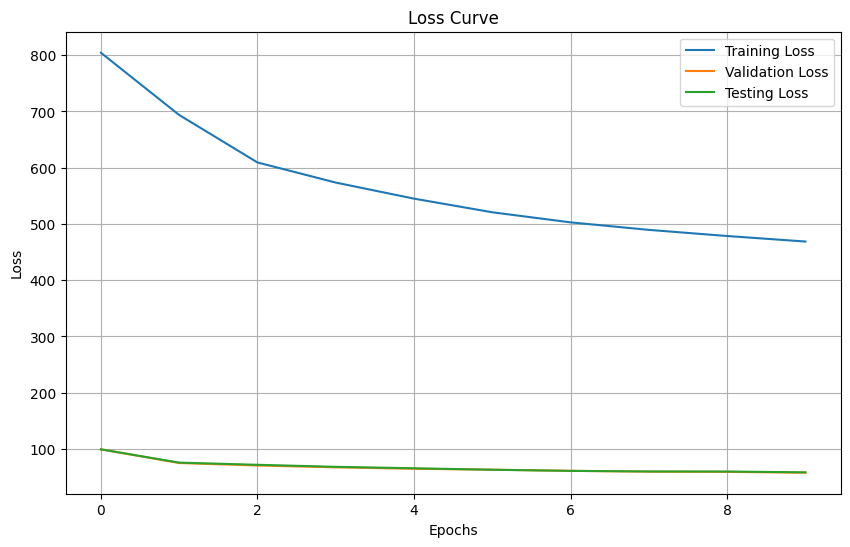

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()